In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import powerlaw
import pylab as p
import torch

In [ ]:
plt.figure(figsize=(12,10))
ax = plt.gca()

a = 0.025
rv = powerlaw(a)
x = np.linspace(0.05,0.5,1000)
y = rv.pdf(x)
plt.plot(x, y, 'k--', lw=2, label='frozen pdf')
ax.fill_between(x, np.zeros(len(x)),y, color="orange", alpha=0.75)

a = 0.01
rv = powerlaw(a)
x = np.linspace(0.05,0.5,1000)
y = rv.pdf(x)
plt.plot(x, y, 'k-', lw=2, label='frozen pdf', alpha=0.75)
ax.fill_between(x, np.zeros(len(x)),y)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.show()

In [ ]:
a = 0.05
rv = powerlaw(a)
x = np.linspace(0.05,0.5,1000)
y = rv.pdf(x)
plt.plot(x, y, 'k-', lw=2, label='frozen pdf')
ax = plt.gca()
ax.fill_between(x, np.zeros(len(x)),y)

In [ ]:
import pandas as pd
df = pd.read_csv("/newfoundland/tarun/datasets/Adaptation/visDA/real/classes.txt", sep="\s", header=None, engine="python")
classids = df[1].values
sorted_classids = torch.Tensor(classids).unfold(dimension=0, size=3, step=1).mean(1).numpy()[::-1]
target_classes = sorted_classids

In [ ]:
plt.figure(figsize=(17,10))
ax = plt.gca()

x = np.arange(len(target_classes))

y = target_classes
ax.fill_between(x, np.zeros(len(x)),y, color="orange", alpha=0.5)

a = 0.01
y = np.sort(target_classes)[::-1]
factor = np.arange(0.05,0.3,0.25/len(target_classes))[::-1]
y_source = y*factor
# rv = powerlaw(a)
# x = np.linspace(0.05,0.5,1000)
# y = rv.pdf(x)
plt.plot(x, y_source, 'k-', lw=2, label='frozen pdf')
ax.fill_between(x, np.zeros(len(x)),y_source)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

# plt.ylabel("Samples per class", fontsize=30, loc="bottom")

plt.show()

In [ ]:
len(target_classes)

## Long tailed DA

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os


from eval import prep, ImageList, AverageMeter, predictor, fine_net

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
classwise_accuracy = {}

In [16]:
source = "sketch"
target = "painting"
file_path = {"real": "./data/visDA_full/real_test.txt" ,
"sketch": "./data/visDA_full/sketch_test.txt" ,
"painting": "./data/visDA_full/painting_test.txt" ,
"clipart": "./data/visDA_full/clipart_test.txt"}
dataset_test = file_path[target]

dataset_list = ImageList("/newfoundland/tarun/datasets/Adaptation/visDA/", open(dataset_test).readlines(), transform=prep.image_test(resize_size=256, crop_size=224))
print("Size of target dataset:" , len(dataset_list))
test_loader = torch.utils.data.DataLoader(dataset_list, batch_size=64, shuffle=False, num_workers=16, drop_last=False)

Size of target dataset: 21850


In [17]:
import pandas as pd
df = pd.read_csv("/newfoundland/tarun/datasets/Adaptation/visDA/%s/classes.txt"%(source), sep="\s", header=None, engine="python")
classnames = (df[0].values).tolist()
class_sizes = dict(zip(df[0], df[1]))
sorted_classes = sorted(class_sizes.items(), key = lambda k : k[1], reverse=True)

sorted_names = [sc[0] for sc in sorted_classes]
sorted_values = [sc[1] for sc in sorted_classes]

In [20]:
for model in ["CDAN", "MemSAC_CAS", "SourceOnly"]:

    my_fine_net = fine_net(345)
    my_fine_net = my_fine_net.cuda()

    if model == "CDAN":
        model_path = os.path.join("snapshot/domainNet_full/" , model, "CDAN_%s%s_QS_48000_BS_32_tau_0-007_lambda_0"%(source, target), "best_model.pth.tar")
    elif model == "SourceOnly":
        model_path = os.path.join("snapshot/domainNet_full/" , model, "MemSAC_%s%s_SourceOnly"%(source, target), "best_model.pth.tar")
    elif model == "MemSAC_CAS":
        model_path = os.path.join("snapshot/domainNet_full/" , model, "%s_%s"%(source, target), "best_model.pth.tar")
    else:
        model_path = os.path.join("snapshot/domainNet_full/" , model, "DANN_%s%s_QS_48000_BS_32_tau_0-007_lambda_0"%(source, target), "best_model.pth.tar")
    saved_state_dict = torch.load(model_path)

    try:
        my_fine_net.load_state_dict(saved_state_dict, strict=True)
    except:
        saved_state_dict = {k.partition("module.")[-1]:v for k,v in saved_state_dict.items()}
        my_fine_net.load_state_dict(saved_state_dict, strict=True)
    my_fine_net.eval();

    correct = {name:0 for name in classnames}
    total = {name:0 for name in classnames}
    accuracy = AverageMeter()
    with torch.no_grad():
        for i , (inputs, labels, path) in enumerate(test_loader):
            print("{0}/{1}".format(i,len(test_loader)) , end="\r")
            inputs = inputs.cuda()
            labels = labels.cuda()
            cnames = [p.split("/")[-2] for p in path]
            outputs = my_fine_net(inputs).detach()
            predictions = outputs.argmax(1)


            accurate_evals = (predictions == labels)
            total_correct = torch.sum(accurate_evals.float())/len(outputs)
            accuracy.update(total_correct.item(), len(outputs))

            for ans, cn in zip(accurate_evals, cnames):
                total[cn] += 1
                if ans == 1:
                    correct[cn] += 1    
    print_str = "\nCorrect Predictions: {}/{}".format(int(accuracy.sum), accuracy.count)
    print_str1 = '\ntest_acc:{:.4f}'.format(accuracy.avg)
    print(print_str + print_str1)

    classwise_accuracy[model] = {cname:correct[cname]/max(total[cname], 1e-5) for cname in total}

341/342
Correct Predictions: 7259/21850
test_acc:0.3322
341/342
Correct Predictions: 9010/21850
test_acc:0.4124
341/342
Correct Predictions: 5167/21850
test_acc:0.2365


In [21]:
sorted_accuracies = {}
for m in ["CDAN", "SourceOnly", "MemSAC_CAS"]:
    sorted_accuracies[m] = [classwise_accuracy[m][sn] for sn in sorted_names]

In [11]:
diff_accuracy = [(a1-a2)*100 for a1,a2 in zip(sorted_accuracies["MemSAC_CAS"], sorted_accuracies["SourceOnly"])]

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(list(range(len(sorted_values))), sorted_values, width=0.2)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(range(len(diff_accuracy)), diff_accuracy)
# plt.xticks(range(len(diff_accuracy)), sorted_names, rotation=45)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()

In [22]:
med1, med2 = 100,20# sorted_values[115], sorted_values[230]
diff_high = np.mean([da for da,cn in zip(sorted_accuracies["MemSAC_CAS"], sorted_values) if cn > med1])
diff_med = np.mean([da for da,cn in zip(sorted_accuracies["MemSAC_CAS"], sorted_values) if cn < med1 and cn>med2 ])
diff_low = np.mean([da for da,cn in zip(sorted_accuracies["MemSAC_CAS"], sorted_values) if cn < med2])
diff_high, diff_med, diff_low ## MSAC

(0.3887819529325238, 0.2634145020859895, 0.2754755621529496)

In [24]:
med1, med2 = 100,20# sorted_values[115], sorted_values[230]
diff_high = np.mean([da for da,cn in zip(sorted_accuracies["CDAN"], sorted_values) if cn > med1])
diff_med = np.mean([da for da,cn in zip(sorted_accuracies["CDAN"], sorted_values) if cn < med1 and cn>med2 ])
diff_low = np.mean([da for da,cn in zip(sorted_accuracies["CDAN"], sorted_values) if cn < med2])
diff_high, diff_med, diff_low ## CDAN

(0.3314024560887172, 0.15246208796858354, 0.015503875968992248)

In [25]:
med1, med2 = 100,20# sorted_values[115], sorted_values[230]
diff_high = np.mean([da for da,cn in zip(sorted_accuracies["SourceOnly"], sorted_values) if cn > med1])
diff_med = np.mean([da for da,cn in zip(sorted_accuracies["SourceOnly"], sorted_values) if cn < med1 and cn>med2 ])
diff_low = np.mean([da for da,cn in zip(sorted_accuracies["SourceOnly"], sorted_values) if cn < med2])
diff_high, diff_med, diff_low ## CDAN

(0.2435454011694886, 0.08881168375129249, 0.0)

In [13]:
med1 = sorted_values[225]
diff_high = np.mean([da for da,cn in zip(diff_accuracy, sorted_values) if cn > med1])
diff_low = np.mean([da for da,cn in zip(diff_accuracy, sorted_values) if cn < med1])
diff_high, diff_low ## CDAN

(15.474826957008371, 21.921580333670732)

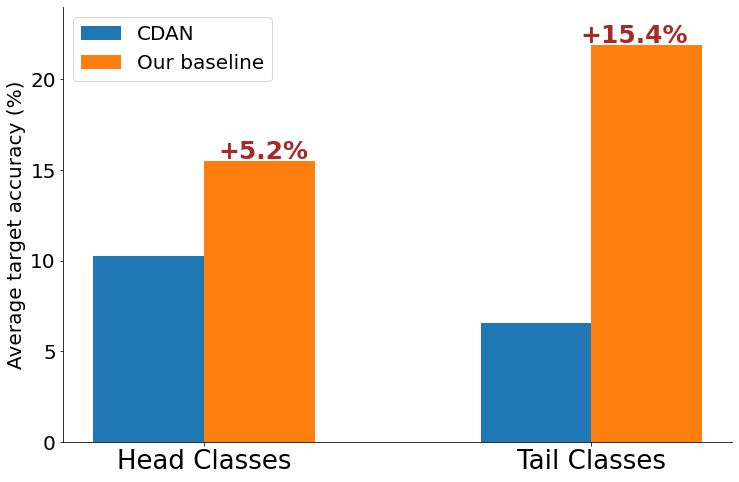

In [14]:
plt.figure(figsize=(12,8))

w=0.1
offset=0.05

idxs = np.array([0,0.35])
plt.bar(idxs-0.05 , [33.1,1.5], width=w, label="CDAN")
plt.bar(idxs+0.05 , [38.8,27.5], width=w, label="Our baseline")

plt.yticks(fontsize=20)
plt.ylabel("Average target accuracy (%)", fontsize=20)

plt.text(0.013, 15.6, "+5.2%", color="brown", fontsize=25, weight="bold")
plt.text(0.34, 22, "+15.4%", color="brown", fontsize=25, weight="bold")

plt.ylim([0,24])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(idxs, ["Head Classes","Tail Classes"], fontsize=26)


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


plt.legend(fontsize=20)

plt.savefig("LongTail.pdf", format="pdf", dpi=1200, bbox_inches='tight')

plt.show()

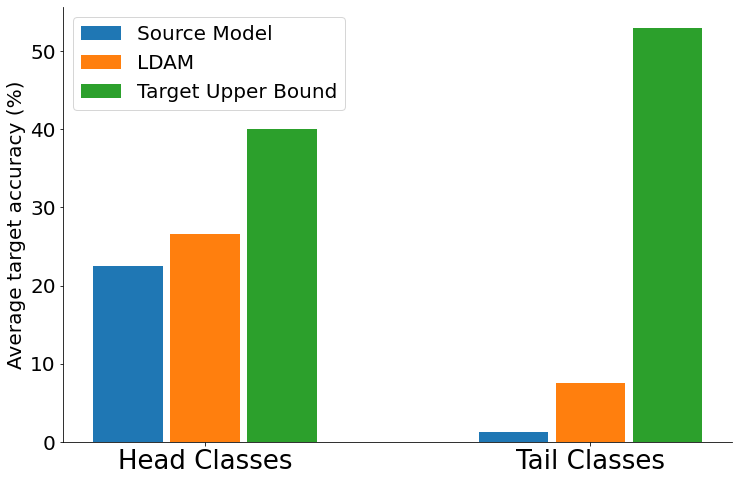

In [13]:
plt.figure(figsize=(12,8))

idxs = np.array([0,0.5])
plt.bar(idxs-0.1, [22.52,1.25], width=0.09, label="Source Model")
plt.bar(idxs, [26.56,  7.49], width=0.09, label="LDAM")
plt.bar(idxs+0.1, [40, 53], width=0.09, label="Target Upper Bound")

plt.yticks(fontsize=20)
plt.ylabel("Average target accuracy (%)", fontsize=20)

# plt.text(0.013, 15.6, "+5.2%", color="brown", fontsize=25, weight="bold")
# plt.text(0.34, 22, "+15.4%", color="brown", fontsize=25, weight="bold")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks([0,0.5], ["Head Classes" ,"Tail Classes"], fontsize=26)


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


plt.legend(fontsize=20)

plt.savefig("LongTail_LDAM.pdf", format="pdf", dpi=1200, bbox_inches='tight')

plt.show()

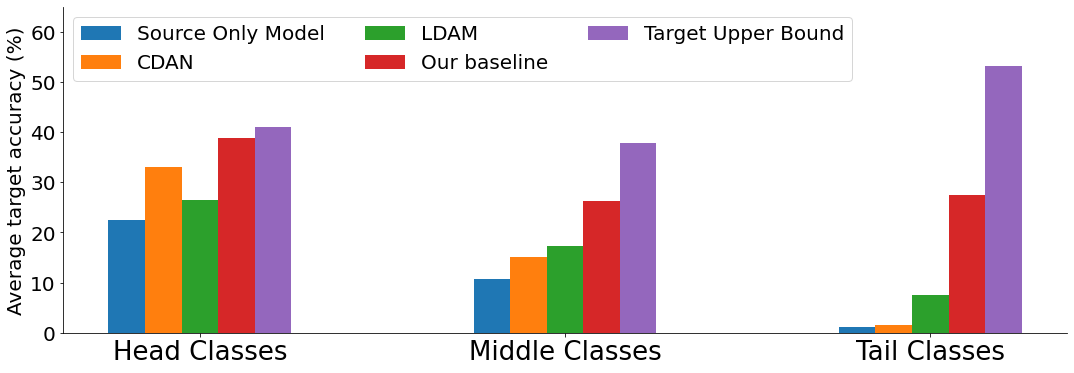

In [38]:
plt.figure(figsize=(18,6))

w=0.05
offset=0.05

source = np.array([22.5,10.76,1.25])
CDAN = np.array([33.1, 15.2, 1.5])
LDAM = np.array([26.56, 17.3, 7.49])
baseline = np.array([38.8, 26.3, 27.50])
target = np.array([40.97, 37.78, 53.19])

idxs = np.array([0.5,1.,1.5])
plt.bar(idxs-0.1 , source, width=w, label="Source Only Model")
plt.bar(idxs-0.05 , CDAN, width=w, label="CDAN")
plt.bar(idxs , LDAM, width=w, label="LDAM")
plt.bar(idxs+0.05 , baseline, width=w, label="Our baseline")
plt.bar(idxs+0.1 , target, width=w, label="Target Upper Bound")


plt.yticks(fontsize=20)
plt.ylabel("Average target accuracy (%)", fontsize=20)

# plt.text(0.013, 15.6, "+5.2%", color="brown", fontsize=25, weight="bold")
# plt.text(0.34, 22, "+15.4%", color="brown", fontsize=25, weight="bold")

plt.ylim([0,65])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(idxs, ["Head Classes","Middle Classes","Tail Classes"], fontsize=26)


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


plt.legend(fontsize=20, ncol=3, loc="upper left")

plt.savefig("LongTail_idea.pdf", format="pdf", dpi=1200, bbox_inches='tight')

plt.show()